# Includes:

In [92]:
%reload_ext autoreload
%autoreload 2
import seaborn as sn
import os
import matplotlib.pyplot as plt

import tf_lite_conversion

from data_paths import get_file_paths_ordered
from pre_process import *
from models import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tensorflow import keras

In [78]:
CSV_DIR = 'csv/'
MODEL_DIR = 'Models/'
MODEL_NAME = 'labmodel.h5'
TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME[:-3]
C_MODEL_NAME = MODEL_NAME[:-3]
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
print("Number of speakers : ", NB_SPEAKERS)

Model names :  labmodel.h5 tflite_labmodel labmodel
Number of speakers :  5


Number of speakers and the percentage of the available samples to use to consider:

In [6]:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85

Read data:

Total number of speakers in the original dataset: 5
Original number of files per speaker :  [1002, 656, 589, 570, 489]
Training number of files per speaker :  2260


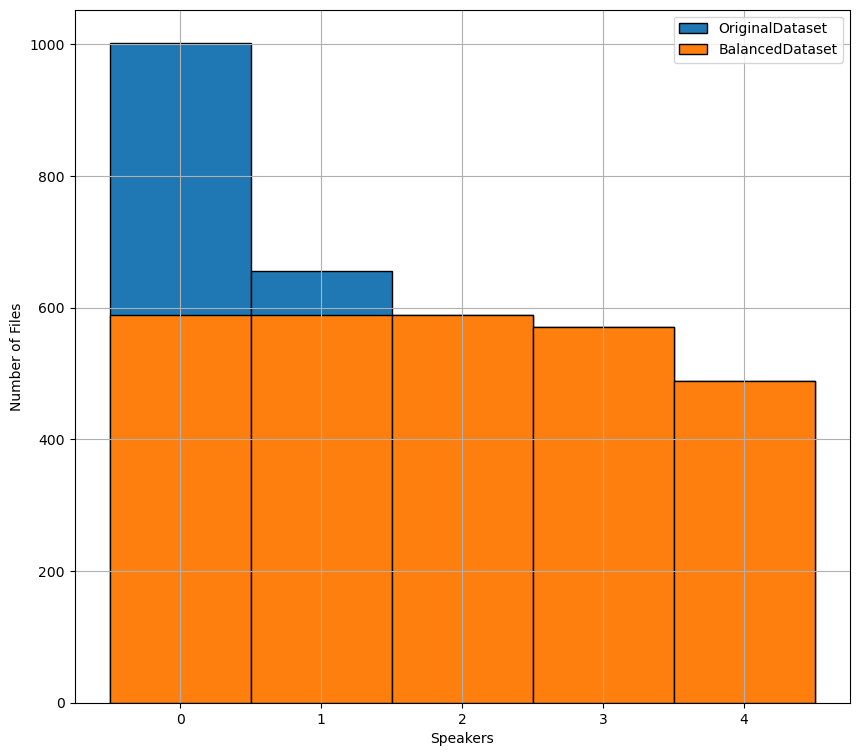

In [10]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True, 
                                                                                    plot_data = True)

Visualization of the samples ...


100%|███████████████████████████████████████████████████████████| 2826/2826 [00:04<00:00, 581.35it/s]


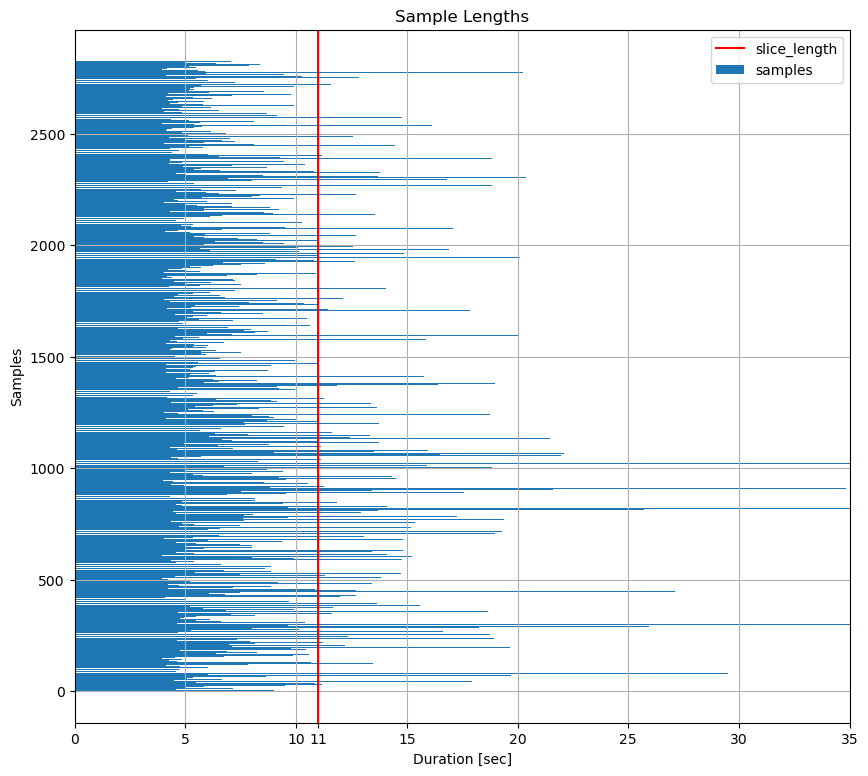

100%|████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 1338.70it/s]


Train - test size :  (2260, 171, 1024) (566, 171, 1024)


In [118]:
seg_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                    y_train_l=y_train_l, y_test_l=y_test_l,
                                                    tot_slice_len=seg_len,
                                                    used_train_sz_rat=dataset_percentage, 
                                                    used_test_sz_rat=dataset_percentage)

print("Train - test size : ", x_train.shape, x_test.shape)

# Pre-Processing:

In [113]:
#from sklearn.model_selection import train_test_split
#x_train, x_val, y_train, y_val = train_test_split(x_train.numpy(), y_train.numpy(), test_size=0.2)

In [119]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13
segmentLength=1024

x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

# Define the Model:

In [120]:
input_shape = x_train_mfcc.shape
model = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=0)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_8 (Conv2D)           (2260, 171, 13, 3)        30        
                                                                 
 batch_normalization_8 (Batc  (2260, 171, 13, 3)       12        
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (2260, 171, 13, 3)        0         
                                                                 
 conv2d_9 (Conv2D)           (2260, 86, 7, 16)         448       
                                                                 
 batch_normalization_9 (Batc  (2260, 86, 7, 16)       

Define learning parameters:

In [121]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 100 # nb of back propagations

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [122]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_best.h5',save_best_only=True),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1.0e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]
# es = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# history = model.fit(x=x_train_mfcc, y=y_train, batch_size=batchSize, epochs=epochs, validation_split=0.2, callbacks=[es])
history = model.fit(
    x = x_train_mfcc, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = batchSize, 
    epochs = epochs
)

Epoch 1/100
57/57 [==============================] - 37s 634ms/step - loss: 1.1267 - accuracy: 0.6001 - val_loss: 1.5790 - val_accuracy: 0.2456
Epoch 2/100
57/57 [==============================] - 4s 54ms/step - loss: 0.6134 - accuracy: 0.8601 - val_loss: 1.4094 - val_accuracy: 0.5332
Epoch 3/100
57/57 [==============================] - 2s 30ms/step - loss: 0.3787 - accuracy: 0.9215 - val_loss: 2.2337 - val_accuracy: 0.3650
Epoch 4/100
57/57 [==============================] - 2s 29ms/step - loss: 0.2697 - accuracy: 0.9347 - val_loss: 2.9624 - val_accuracy: 0.3805
Epoch 5/100
57/57 [==============================] - 1s 25ms/step - loss: 0.2140 - accuracy: 0.9463 - val_loss: 2.3017 - val_accuracy: 0.5221
Epoch 6/100
57/57 [==============================] - 2s 30ms/step - loss: 0.1483 - accuracy: 0.9629 - val_loss: 2.7113 - val_accuracy: 0.4690
Epoch 7/100
57/57 [==============================] - 1s 26ms/step - loss: 0.1319 - accuracy: 0.9602 - val_loss: 4.8585 - val_accuracy: 0.4292
Epoc

Evaluate the performance on the test set:

In [123]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 6ms/step
18/18 - 0s - loss: 0.2366 - accuracy: 0.9364 - 109ms/epoch - 6ms/step
Test accuracy: 0.9363957643508911
Test loss: 0.23663166165351868


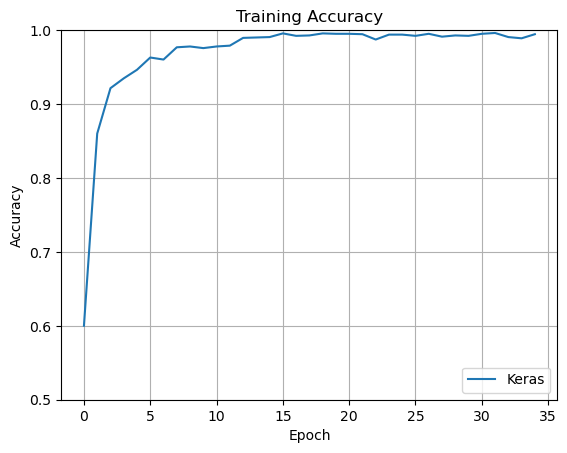

In [124]:
plt.plot(history.history['accuracy'], label='Keras')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Training Accuracy")
plt.show()

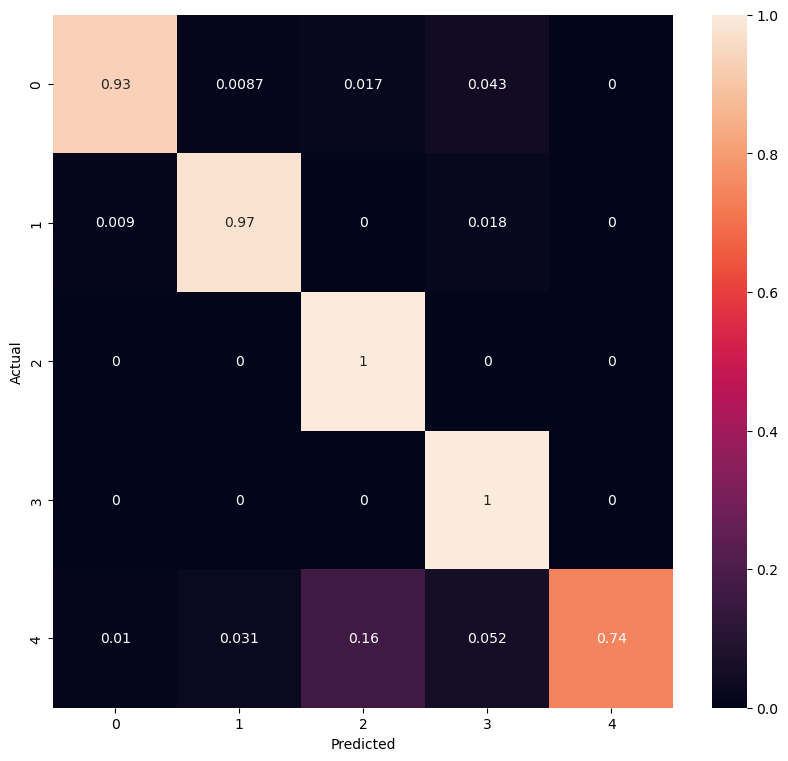

In [125]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [79]:
model.save(MODEL_DIR + MODEL_NAME)

Test image data location:  C:\Users\erolland\Documents\mcu\project\X_train.csv
Test labels location:  C:\Users\erolland\Documents\mcu\project\Y_train.csv


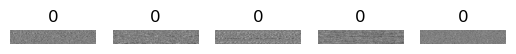

In [77]:
def save_array_to_file(x, y, x_file, y_file, path):
    np.save(CSV_DIR + x_file, x.astype(np.uint8))
    np.save(CSV_DIR + y_file, y)
    # plot the first 5 images in the test set with their labels
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x.astype(np.uint8)[i], cmap='gray')
        plt.title(np.argmax(y[i]))
        plt.axis('off')

    # print the location of the files
    print('Test image data location: ', os.path.abspath(x_file))
    print('Test labels location: ', os.path.abspath(y_file))
    
save_array_to_file(x_train.astype(np.uint8), y_train, 'X_train.csv', 'Y_train.csv', CSV_DIR)

In [80]:
# Show the model size for the non-quantized HDF5 model
h5_in_kb = os.path.getsize(MODEL_DIR + MODEL_NAME) / 1024
print("HDF5 Model size without quantization: %d KB" % h5_in_kb)

HDF5 Model size without quantization: 326 KB


# TF Lite Conversion and Quantization:

In [24]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_DIR + MODEL_NAME) 

In [25]:
train_set = x_train_mfcc
train_set.numpy().shape

(1808, 171, 13, 1)

In [93]:
tflite_model = tf_lite_conversion.convert_to_tf_lite(x_train_mfcc,model,MODEL_DIR + TFLITE_MODEL_NAME)

INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmp6syxopk1\assets


INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmp6syxopk1\assets
C:\Apps\Anaconda3\envs\ml\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [83]:
# Show the model size for the non-quantized TFLite model
tflite_quant_in_kb = os.path.getsize(MODEL_DIR + TFLITE_MODEL_NAME + '.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (h5_in_kb / tflite_quant_in_kb))

TFLite Model size with 8-bit quantization: 28 KB

Reduction in model size by a factor of 11.581556


# C conversion

In [94]:
# Write TFLite model to a C source (or header) file
from c_code_conversion import *
with open(MODEL_DIR + C_MODEL_NAME + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, C_MODEL_NAME))

In [95]:
quan_test_dat_path = '../QuantizedTestData/'

# Create the directory
if not os.path.exists(quan_test_dat_path):
    os.makedirs(quan_test_dat_path)
    
# save the test data as numpy arrays
np.save(quan_test_dat_path + 'x_test_voxceleb.npy', tf.cast(x_test_mfcc, dtype=tf.uint8))#.astype(np.uint8))
np.save(quan_test_dat_path + 'y_test_voxceleb.npy', y_test)

#save_array_to_file(x_train.astype(np.uint8), y_train, 'X_train.csv', 'Y_train.csv', CSV_DIR)

# Test the model

We can test the model using the tflite interpreter. We can use the set_tensor() function to set the input data and the invoke() function to run the model. We can then use the get_tensor() function to get the output data. More information can be found in the tflite interpreter documentation.

In [96]:
# Test the model using the tflite interpreter with quantization
interpreter = tf.lite.Interpreter(model_path=MODEL_DIR+TFLITE_MODEL_NAME+'.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print some information about the input and output tensors
print("Input shape is {} and of type {}".format(input_details[0]['shape'], input_details[0]['dtype']))
print("Output shape is {} and of type {}".format(output_details[0]['shape'], output_details[0]['dtype']))
     

Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>


In [97]:
input_data = tf.cast(tf.cast(x_test_mfcc, tf.int32)-128, tf.int8)
input_shape = input_details[0]['shape']
interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [98]:
from sklearn.metrics import accuracy_score
print("Accuracy of quantized model is: ", accuracy_score(y_test, np.argmax(output_data, axis=1)))

Accuracy of quantized model is:  0.17314487632508835


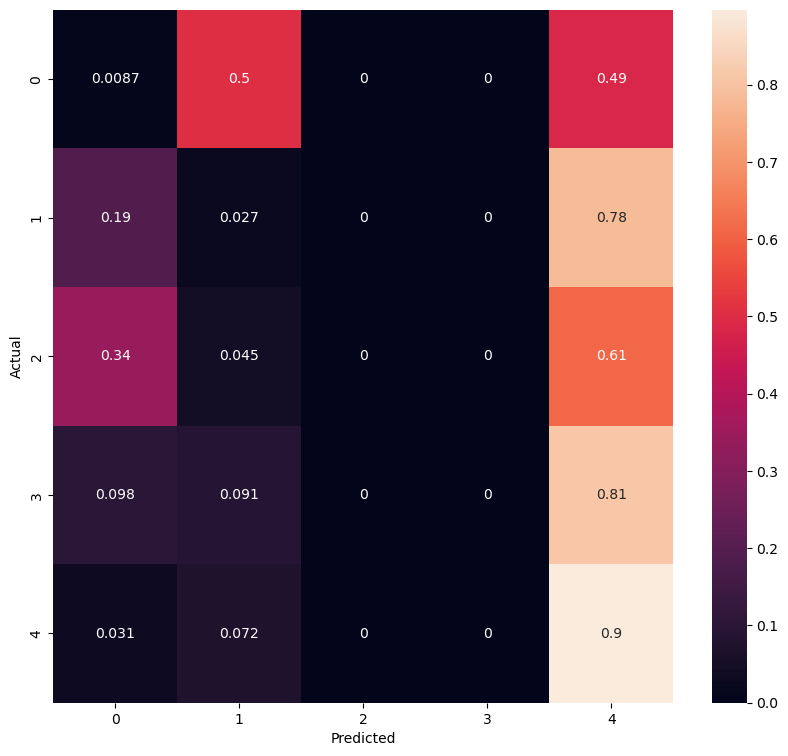

In [42]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, np.argmax(output_data, axis=1), 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
tflite_interpreter = tf.lite.Interpreter(model_path=MODEL_DIR+TFLITE_MODEL_NAME + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_normalization_2_input:0
shape: [  1 171  13   1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 5]
type: <class 'numpy.int8'>


In [100]:
test_set = x_test_mfcc
predictions = np.zeros((len(test_set),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(test_set)):
    val_batch = test_set[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
     

In [111]:
sum = 0
test_labels = y_test
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
        
tflite_score = accuracy_score(y_test, predictions)
print(sum, test_labels.shape, sum/len(test_labels))
print("Accuracy of quantized to int8 model is {}%".format(tflite_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_score-test_acc)*100))

557 (566,) 0.9840989399293286
Accuracy of quantized to int8 model is 98.40989399293287%
Compared to float32 accuracy of 99.46996569633484%
We have a change of -1.0600717034019769%


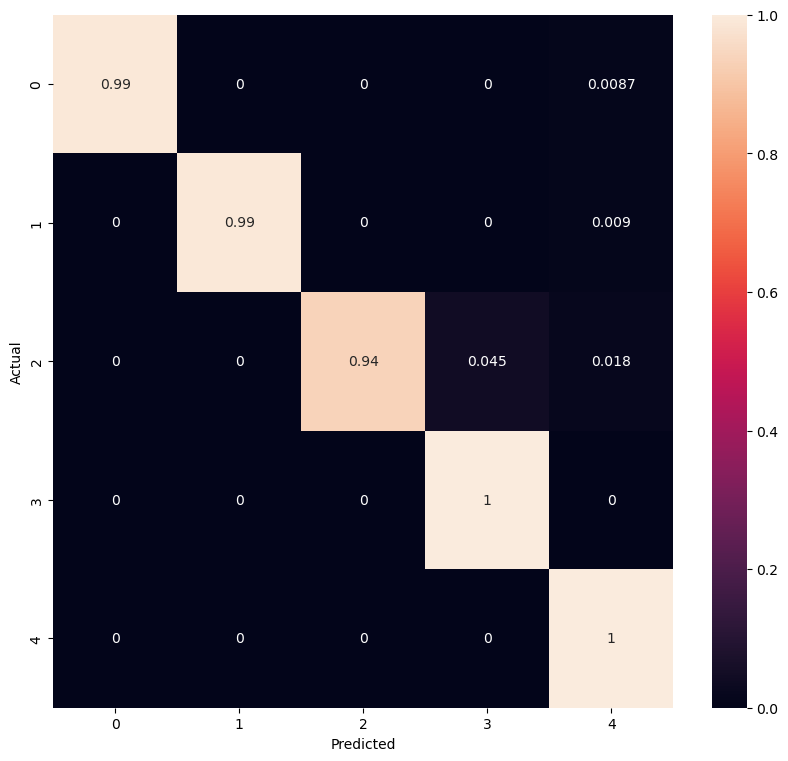

In [103]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, predictions, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()